In [ ]:

import math
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Reproducibility: set all random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


device = torch.device("cuda")


## 2. Load Tiny Shakespeare corpus


In [ ]:
# Path to the Tiny Shakespeare file in the Colab environment
DATA_PATH = "/content/input.txt"

# Basic sanity check to avoid silent failures
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"

# Read the entire corpus into a single string
with open(DATA_PATH, "r", encoding="utf-8") as f:
    text = f.read()

print(f"Total number of characters in the corpus: {len(text)}")
print("\n=== Sample from the corpus ===")
print(text[:500])

Total number of characters in the corpus: 1115394

=== Sample from the corpus ===
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


## 3.tokenization (Byte-Pair Encoding)


Here we use Hugging Face's `tokenizers` library to train a BPE tokenizer on the
Tiny Shakespeare corpus.

Design choices:

- `vocab_size ≤ 500` to keep the model small.  
- Whitespace pre-tokenizer  
- Special tokens: `[PAD]` and `[UNK]`.  


In [ ]:

!pip install -q tokenizers

from tokenizers import Tokenizer, models, trainers, pre_tokenizers

In [ ]:
def train_bpe_tokenizer(text: str, vocab_size: int = 500) -> Tokenizer:
    """Train a Byte-Pair Encoding tokenizer on the given text.

    Args:
        text: Entire corpus as a single string.
        vocab_size: Target vocabulary size (including special tokens).

    Returns:
        A trained `Tokenizer` instance.
    """
    # BPE model with an explicit unknown token
    tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))

    # Split on whitespace; BPE merges are learned on top of this
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

    # Trainer configuration
    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size,
        min_frequency=2,               # ignore rare subwords
        special_tokens=["[PAD]", "[UNK]"],
        show_progress=True,
    )

    # Train from an iterator of lines to avoid loading the corpus multiple times
    lines = text.splitlines()
    tokenizer.train_from_iterator(lines, trainer)

    return tokenizer


# Target vocabulary size suggested by the assignment
VOCAB_SIZE_TARGET = 500

tokenizer = train_bpe_tokenizer(text, vocab_size=VOCAB_SIZE_TARGET)
vocab_size = tokenizer.get_vocab_size()

print("Actual vocabulary size learned by BPE:", vocab_size)

# Quick sanity check: encode and decode a short snippet
example = "First Citizen: Speak, speak."
encoded = tokenizer.encode(example)
print("\nExample sentence:", example)
print("Tokens:", encoded.tokens)
print("Token IDs:", encoded.ids)
print("Decoded back:", tokenizer.decode(encoded.ids))

Actual vocabulary size learned by BPE: 500

Example sentence: First Citizen: Speak, speak.
Tokens: ['First', 'C', 'it', 'i', 'z', 'en', ':', 'S', 'pe', 'ak', ',', 'speak', '.']
Token IDs: [405, 15, 91, 47, 64, 73, 10, 31, 152, 250, 6, 363, 8]
Decoded back: First C it i z en : S pe ak , speak .


## 4. Sequence formatting for next-token prediction

We transform the full tokenized corpus into **overlapping fixed-length
sequences**. For each sequence of length `T`:

- **Input**: `input[t] = token_ids[i + t]` (first `T` tokens)  
- **Target**: `target[t] = token_ids[i + t + 1]` (sequence shifted by one)

 at each position
the model predicts the **next token**.

In [ ]:
# Encode the entire corpus into a list of token IDs
encoded_corpus = tokenizer.encode(text)
all_ids = encoded_corpus.ids
print("Total number of BPE tokens in the corpus:", len(all_ids))
print("First 50 token IDs:", all_ids[:50])

# sequence length used by the Transformer.
SEQ_LEN = 50


def build_sequences(token_ids, seq_len: int = SEQ_LEN):
    """Build overlapping (input, target) sequences.

    Args:
        token_ids: List of integer token IDs.
        seq_len: Length of each fixed sequence (L).

    Returns:
        inputs: 2D numpy array of shape (num_sequences, seq_len)
        targets: 2D numpy array of shape (num_sequences, seq_len)
    """
    inputs = []
    targets = []
    # We stop at len(token_ids) - seq_len - 1 to have room for the shifted target
    for i in range(len(token_ids) - seq_len):
        x = token_ids[i : i + seq_len]
        y = token_ids[i + 1 : i + seq_len + 1]
        inputs.append(x)
        targets.append(y)

    inputs = np.array(inputs, dtype=np.int64)
    targets = np.array(targets, dtype=np.int64)
    return inputs, targets


inputs, targets = build_sequences(all_ids, SEQ_LEN)
print("Number of (input, target) sequences:", len(inputs))
print("Shape of inputs:", inputs.shape)
print("Shape of targets:", targets.shape)
print("inputs[0]: ", inputs[0])
print("targets[0]:", targets[0])

Total number of BPE tokens in the corpus: 447717
First 50 token IDs: [405, 15, 91, 47, 64, 73, 10, 394, 281, 114, 298, 99, 108, 422, 44, 136, 129, 6, 393, 79, 363, 8, 13, 78, 10, 31, 152, 250, 6, 363, 8, 405, 15, 91, 47, 64, 73, 10, 316, 156, 133, 56, 84, 314, 90, 42, 143, 129, 80, 275]
Number of (input, target) sequences: 447667
Shape of inputs: (447667, 50)
Shape of targets: (447667, 50)
inputs[0]:  [405  15  91  47  64  73  10 394 281 114 298  99 108 422  44 136 129   6
 393  79 363   8  13  78  10  31 152 250   6 363   8 405  15  91  47  64
  73  10 316 156 133  56  84 314  90  42 143 129  80 275]
targets[0]: [ 15  91  47  64  73  10 394 281 114 298  99 108 422  44 136 129   6 393
  79 363   8  13  78  10  31 152 250   6 363   8 405  15  91  47  64  73
  10 316 156 133  56  84 314  90  42 143 129  80 275  43]


### 4.1 Train / validation split and DataLoaders

We split the sequences **80% / 20%** into training and validation sets

In [ ]:
# 80 / 20 split along the sequence dimension
split_idx = int(0.8 * len(inputs))

train_inputs, val_inputs = inputs[:split_idx], inputs[split_idx:]
train_targets, val_targets = targets[:split_idx], targets[split_idx:]

print(f"Train sequences: {len(train_inputs)}, Validation sequences: {len(val_inputs)}")

class ShakespeareDataset(Dataset):
    """Simple Dataset wrapper around (input, target) arrays."""

    def __init__(self, inputs: np.ndarray, targets: np.ndarray):
        assert inputs.shape == targets.shape
        self.inputs = torch.from_numpy(inputs).long()
        self.targets = torch.from_numpy(targets).long()

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        # Returns a pair of tensors: (input_sequence, target_sequence)
        return self.inputs[idx], self.targets[idx]

BATCH_SIZE = 64
train_ds = ShakespeareDataset(train_inputs, train_targets)
val_ds   = ShakespeareDataset(val_inputs, val_targets)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

print("Train batches per epoch:", len(train_loader))
print("Val batches per epoch:", len(val_loader))

Train sequences: 358133, Validation sequences: 89534
Train batches per epoch: 5596
Val batches per epoch: 1399


## 5. Transformer model



In [ ]:
# Transformer hyperparameters
D_MODEL = 64        # Embedding dimension / hidden size
N_HEADS = 2          # Number of attention heads
N_LAYERS = 2         # Number of Transformer blocks
D_FF = 128           # Hidden layer size in feed-forward network
DROPOUT = 0.2        # Dropout probability
MAX_SEQ_LEN = SEQ_LEN  # Maximum supported sequence length

vocab_size = tokenizer.get_vocab_size()
print("Using vocabulary size =", vocab_size)

Using vocabulary size = 500


In [ ]:
class PositionalEncoding(nn.Module):
    """Standard sinusoidal positional encoding.

    """

    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()

        # Create a (max_len, d_model) matrix filled with zeros
        pe = torch.zeros(max_len, d_model)

        # Position indices (0, 1, 2, ..., max_len - 1)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)

        # Compute the geometric progression for the frequencies
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even dimensions and cosine to odd dimensions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add a batch dimension so shape becomes (1, max_len, d_model)
        pe = pe.unsqueeze(0)

        # Register as buffer so it is moved to the right device with the model,
        # but is not treated as a learnable parameter
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Add positional encodings to the input.

        Args:
            x: Input tensor of shape (batch_size, seq_len, d_model).

        Returns:
            Tensor of the same shape with positional encodings added.
        """
        seq_len = x.size(1)
        # Add the first seq_len positions from precomputed encodings
        return x + self.pe[:, :seq_len]

In [ ]:
class RMSNorm(nn.Module):
    """Root Mean Square Layer Normalization (RMSNorm).

    """

    def __init__(self, d_model: int, eps: float = 1e-8):
        super().__init__()
        self.eps = eps
        # Learnable scale parameter (one per feature)
        self.scale = nn.Parameter(torch.ones(d_model))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Compute root mean square along the last dimension
        # Shape of x: (batch, seq_len, d_model)
        rms = x.norm(dim=-1, keepdim=True) / math.sqrt(x.size(-1))
        return self.scale * x / (rms + self.eps)


class PositionwiseFFN(nn.Module):
    """Position-wise feed-forward network (applied independently at each token)."""

    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.0):
        super().__init__()
        self.lin1 = nn.Linear(d_model, d_ff)
        self.lin2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Shape of x: (batch, seq_len, d_model)
        x = self.lin1(x)
        x = F.gelu(x)        # Non-linearity (GELU is common in modern Transformers)
        x = self.dropout(x)
        x = self.lin2(x)
        return x

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    """Multi-head self-attention with optional causal mask.

    """

    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.0):
        super().__init__()

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        # Linear projections for queries, keys, and values
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)

        # Output projection after concatenating all heads
        self.o_proj = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

        # We store the attention weights of the last forward pass
        # for visualization purposes (detach to avoid backprop through them)
        self.last_attn_weights = None

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor = None) -> torch.Tensor:
        """Compute multi-head self-attention.

        Args:
            x: Input tensor of shape (batch_size, seq_len, d_model).
            attn_mask: Optional mask tensor broadcastable to shape
                       (batch_size, num_heads, seq_len, seq_len),
                       typically containing 0 for allowed positions and -inf
                       for masked positions (added to attention logits).

        Returns:
            Tensor of shape (batch_size, seq_len, d_model).
        """
        B, T, C = x.size()  # Batch, sequence length, embedding dim

        # 1) Project input to queries, keys, and values
        q = self.q_proj(x)  # (B, T, C)
        k = self.k_proj(x)  # (B, T, C)
        v = self.v_proj(x)  # (B, T, C)

        # 2) Reshape to (B, num_heads, T, head_dim)
        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        # 3) Compute scaled dot-product attention scores
        #    scores[b, h] has shape (T, T)
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)  # (B, H, T, T)

        # 4)apply a mask (causal mask)
        if attn_mask is not None:
            scores = scores + attn_mask

        # 5) Softmax over the last dimension to get attention probabilities
        attn = F.softmax(scores, dim=-1)  # (B, H, T, T)
        attn = self.dropout(attn)

        # Save attention weights (first detach from computation graph)
        self.last_attn_weights = attn.detach().cpu()

        # 6) Multiply by values to get a weighted sum for each head
        out = attn @ v  # (B, H, T, head_dim)

        # 7) Concatenate all heads and apply the output projection
        out = out.transpose(1, 2).contiguous().view(B, T, C)  # (B, T, d_model)
        out = self.o_proj(out)

        return out

In [ ]:
class TransformerBlock(nn.Module):
    """Single Transformer block: attention + feed-forward with residuals."""

    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.0):
        super().__init__()
        self.attn = MultiHeadSelfAttention(d_model, num_heads, dropout=dropout)
        self.norm1 = RMSNorm(d_model)
        self.ffn = PositionwiseFFN(d_model, d_ff, dropout=dropout)
        self.norm2 = RMSNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor = None) -> torch.Tensor:
        # ----- Self-attention sub-layer -----
        # Apply RMSNorm before attention (Pre-LN style)
        h = self.norm1(x)
        h = self.attn(h, attn_mask=attn_mask)
        # Residual connection + dropout
        x = x + self.dropout(h)

        # ----- Feed-forward sub-layer -----
        h2 = self.norm2(x)
        h2 = self.ffn(h2)
        # Residual connection + dropout
        x = x + self.dropout(h2)

        return x

In [ ]:
class TransformerLM(nn.Module):
    """A Transformer-based language model for next-token prediction."""

    def __init__(
        self,
        vocab_size: int,
        d_model: int,
        n_heads: int,
        n_layers: int,
        d_ff: int,
        max_seq_len: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        # Token embedding table: maps token IDs to vectors in R^{d_model}
        self.token_emb = nn.Embedding(vocab_size, d_model)

        # Positional encoding (fixed sinusoidal)
        self.pos_enc = PositionalEncoding(d_model, max_len=max_seq_len)

        # Stack of Transformer blocks
        self.layers = nn.ModuleList(
            [TransformerBlock(d_model, n_heads, d_ff, dropout=dropout) for _ in range(n_layers)]
        )

        # Final RMSNorm layer before the output projection
        self.norm_final = RMSNorm(d_model)

        # Language modeling head: linear projection to vocabulary size
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

        self.max_seq_len = max_seq_len

    def generate_causal_mask(self, seq_len: int, device: torch.device) -> torch.Tensor:
        """Generate a standard lower-triangular causal mask.

        The mask has shape (1, 1, seq_len, seq_len) so that it can be
        broadcast over batch and heads. Positions i are prevented from attending
        to positions j where j > i (future tokens).
        """
        # Upper triangular part (excluding diagonal) is 1; rest is 0
        mask = torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1)
        # Convert 1s into -inf and 0s into 0.0
        mask = mask.masked_fill(mask == 1, float("-inf"))
        # Add batch and head dimensions
        return mask.unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, seq_len)

    def forward(self, idx: torch.Tensor, targets: torch.Tensor = None):
        """Forward pass of the language model.

        Args:
            idx: Input token IDs of shape (batch_size, seq_len).
            targets: Optional target token IDs of the same shape. If provided,
                     the method also returns the cross-entropy loss.

        Returns:
            logits: Tensor of shape (batch_size, seq_len, vocab_size).
            loss:   Scalar cross-entropy loss (or None if no targets provided).
        """
        B, T = idx.size()
        assert T <= self.max_seq_len, "Sequence length exceeds model's max_seq_len."

        # 1) Embed tokens and add positional encodings
        x = self.token_emb(idx)  # (B, T, d_model)
        x = self.pos_enc(x)      # (B, T, d_model)

        # 2) Build a causal mask once for this sequence length
        attn_mask = self.generate_causal_mask(T, idx.device)

        # 3) Run through all Transformer blocks
        for layer in self.layers:
            x = layer(x, attn_mask=attn_mask)

        # 4) Final RMSNorm and output projection
        x = self.norm_final(x)          # (B, T, d_model)
        logits = self.lm_head(x)        # (B, T, vocab_size)

        loss = None
        if targets is not None:
            # Cross-entropy loss over flattened time and batch dimensions
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),  # (B*T, vocab_size)
                targets.view(-1),                  # (B*T,)
            )

        return logits, loss

In [ ]:
# Instantiate the Transformer model and move it to device
model = TransformerLM(
    vocab_size=vocab_size,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    d_ff=D_FF,
    max_seq_len=MAX_SEQ_LEN,
    dropout=DROPOUT,
).to(device)

# AdamW optimizer
LR = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)

# Print total number of parameters (in millions) for reference
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of model parameters: {num_params / 1e6:.3f} M")

Number of model parameters: 0.131 M


## 6. Training loop and evaluation

We train the model using **cross-entropy loss** for next-token prediction,
and evaluate on the validation set after each epoch.

The main quantitative metric reported  is **perplexity (PPL)**:


In [ ]:
def train_one_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    grad_clip: float = 1.0,
) -> float:
    """Run a single training epoch over the given DataLoader.

    Args:
        model: The language model.
        dataloader: DataLoader over the training dataset.
        optimizer: Optimizer (e.g., AdamW).
        device: torch.device (CPU or GPU).
        grad_clip: Maximum gradient norm for clipping (to stabilize training).

    Returns:
        Average training loss over this epoch.
    """
    model.train()
    total_loss = 0.0

    for x, y in dataloader:
        # Move data to device
        x = x.to(device)
        y = y.to(device)

        # Reset gradients from the previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass: compute logits and loss
        _, loss = model(x, targets=y)

        # Backward pass: compute gradients
        loss.backward()

        # Optional gradient clipping to avoid exploding gradients
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # Parameter update
        optimizer.step()

        total_loss += loss.item()

    # Average loss across batches
    return total_loss / len(dataloader)


@torch.no_grad()
def evaluate(model: nn.Module, dataloader: DataLoader, device: torch.device) -> float:
    """Evaluate the model on a given DataLoader without gradient computation."""
    model.eval()
    total_loss = 0.0

    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)

        _, loss = model(x, targets=y)
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
def plot_attention_head(attn, tokens, head_idx: int = 0):
    """Plot a single attention head as a heatmap.

    Args:
        attn: Numpy array of shape (num_heads, seq_len, seq_len)
              containing attention weights for one layer.
        tokens: List of string tokens (length = seq_len).
        head_idx: Index of the head to visualize (0-based).
    """
    num_heads, T, _ = attn.shape
    head_idx = max(0, min(head_idx, num_heads - 1))

    attn_head = attn[head_idx]  # (T, T)

    plt.figure(figsize=(7, 7))
    plt.imshow(attn_head, aspect="auto")
    plt.xticks(range(T), tokens, rotation=90)
    plt.yticks(range(T), tokens)
    plt.xlabel("Key / Source position")
    plt.ylabel("Query / Target position")
    plt.title(f"Attention head {head_idx}")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [ ]:
@torch.no_grad()
def get_attention_for_example(
    model: TransformerLM,
    tokenizer: Tokenizer,
    text_snippet: str,
    layer_idx: int = 0,
):
    """Run the model on a short text snippet and return attention weights.

    Args:
        model: Trained TransformerLM model.
        tokenizer: BPE tokenizer used for training.
        text_snippet: Raw text to encode and feed into the model.
        layer_idx: Which Transformer layer's attention to visualize.

    Returns:
        tokens: List of token strings of length SEQ_LEN.
        attn: Numpy array of shape (num_heads, SEQ_LEN, SEQ_LEN) containing
              attention weights for the specified layer.
    """
    model.eval()

    # Encode the snippet to token IDs
    enc = tokenizer.encode(text_snippet)
    ids = enc.ids[:SEQ_LEN]     # Truncate if longer than SEQ_LEN
    tokens = enc.tokens[:SEQ_LEN]

    # If the snippet is shorter than SEQ_LEN, pad with [PAD] tokens
    pad_id = tokenizer.token_to_id("[PAD]")
    if len(ids) < SEQ_LEN:
        pad_len = SEQ_LEN - len(ids)
        ids += [pad_id] * pad_len
        tokens += ["[PAD]"] * pad_len

    # Shape: (1, SEQ_LEN)
    token_ids = torch.tensor(ids, dtype=torch.long, device=device).unsqueeze(0)

    # Run a forward pass to populate attention weights
    _ = model(token_ids)

    # Clamp layer_idx to valid range
    layer_idx = max(0, min(layer_idx, len(model.layers) - 1))

    # Retrieve attention weights from the chosen layer.
    # Shape: (batch_size=1, num_heads, T, T)
    attn = model.layers[layer_idx].attn.last_attn_weights
    # Remove the batch dimension and move to NumPy
    attn = attn.squeeze(0).cpu().numpy()  # (num_heads, T, T)

    return tokens, attn


[Before Training] Attention map (layer 0, head 0):


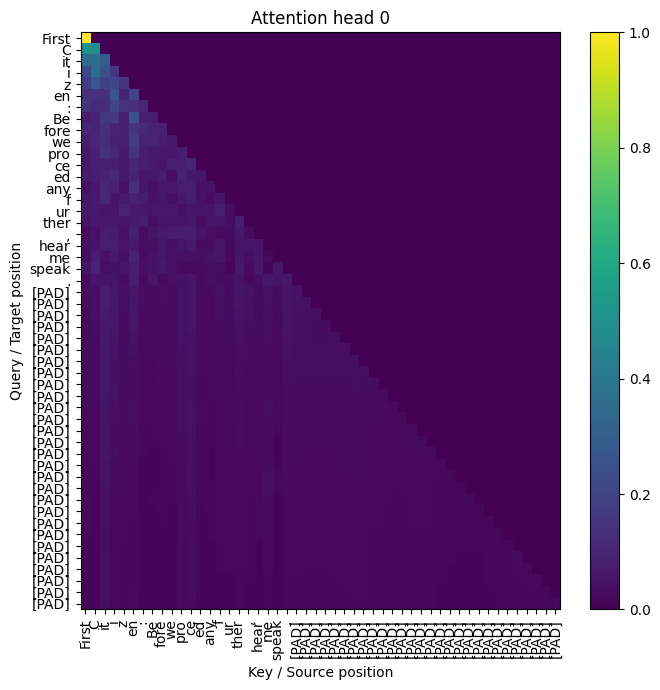

Epoch 01 | train_loss = 4.2943 | val_loss = 4.3220

[After Epoch 1] Attention map (layer 0, head 0):


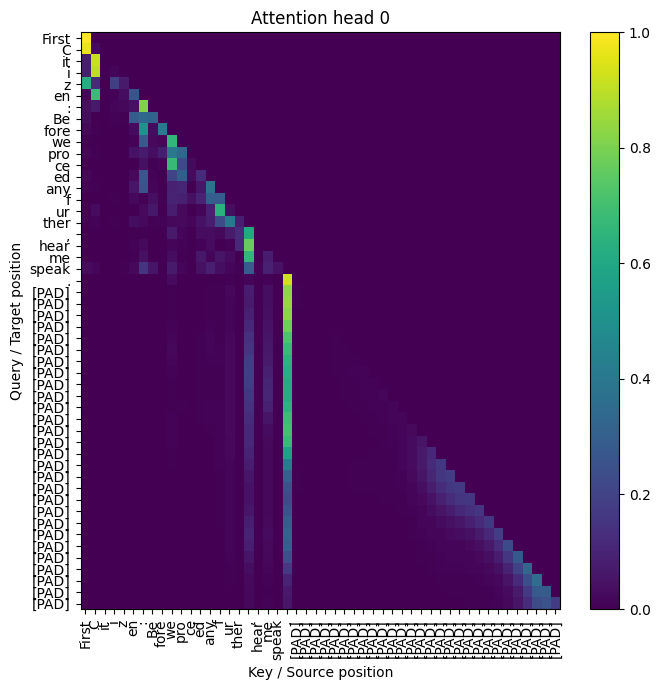

Epoch 02 | train_loss = 3.8733 | val_loss = 4.2337

[After Epoch 2] Attention map (layer 0, head 0):


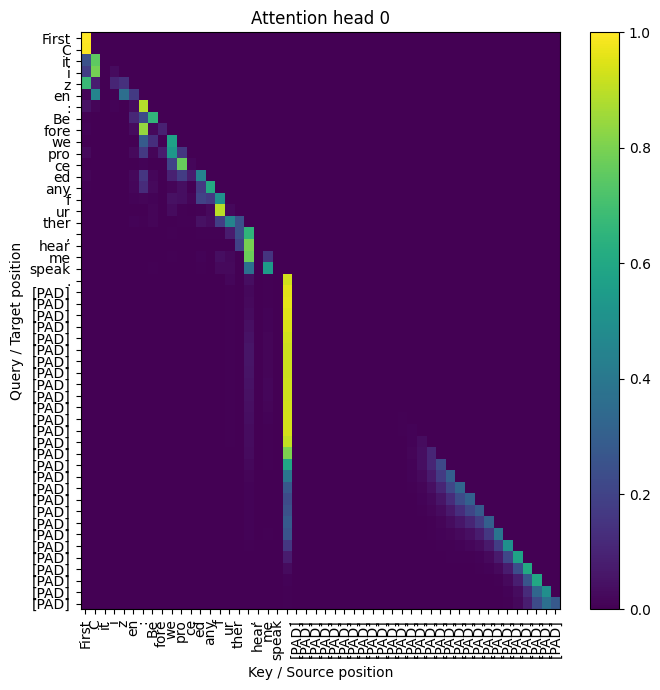

Epoch 03 | train_loss = 3.7652 | val_loss = 4.1982
Epoch 04 | train_loss = 3.7033 | val_loss = 4.1791
Epoch 05 | train_loss = 3.6604 | val_loss = 4.1674
Epoch 06 | train_loss = 3.6278 | val_loss = 4.1585
Epoch 07 | train_loss = 3.6010 | val_loss = 4.1394
Epoch 08 | train_loss = 3.5795 | val_loss = 4.1417
Epoch 09 | train_loss = 3.5614 | val_loss = 4.1387
Epoch 10 | train_loss = 3.5463 | val_loss = 4.1277

Final validation loss: 4.127692525262403
Validation perplexity: 62.03461435240581


In [ ]:
# Number of training epochs
EPOCHS = 10

train_losses = []
val_losses   = []

# Text, layer, and head used to visualize attention
example_text = "First Citizen: Before we proceed any further, hear me speak."
layer_to_viz = 0   # Which transformer layer to visualize
head_to_viz  = 0   # Which attention head to visualize


# ============================================================
# (0) Visualize attention BEFORE ANY TRAINING
# ============================================================
print("\n[Before Training] Attention map (layer 0, head 0):")
tokens_vis, attn_vis = get_attention_for_example(
    model,
    tokenizer,
    example_text,
    layer_idx=layer_to_viz,
)
plot_attention_head(attn_vis, tokens_vis, head_idx=head_to_viz)



# ============================================================
# (1) Training loop
# Only plot attention after epoch 1 and epoch 2
# ============================================================
for epoch in range(EPOCHS):

    # ---- Train for one epoch ----
    train_loss = train_one_epoch(model, train_loader, optimizer, device)

    # ---- Evaluate on validation set ----
    val_loss   = evaluate(model, val_loader, device)

    # Record losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Display epoch results
    print(f"Epoch {epoch + 1:02d} | "
          f"train_loss = {train_loss:.4f} | val_loss = {val_loss:.4f}")

    # ---- Plot attention after epoch 1 and 2 ----
    if epoch in (0, 1):   # epoch=0 → after first epoch, epoch=1 → after second
        print(f"\n[After Epoch {epoch + 1}] Attention map (layer 0, head 0):")
        tokens_vis, attn_vis = get_attention_for_example(
            model,
            tokenizer,
            example_text,
            layer_idx=layer_to_viz,
        )
        plot_attention_head(attn_vis, tokens_vis, head_idx=head_to_viz)



# ============================================================
# (2) Final perplexity calculation
# ============================================================
final_val_loss = val_losses[-1]
val_ppl = math.exp(final_val_loss)

print("\nFinal validation loss:", final_val_loss)
print("Validation perplexity:", val_ppl)


## 7. Visualization – training and validation loss curves

We now visualize how the training and validation loss evolve over epochs

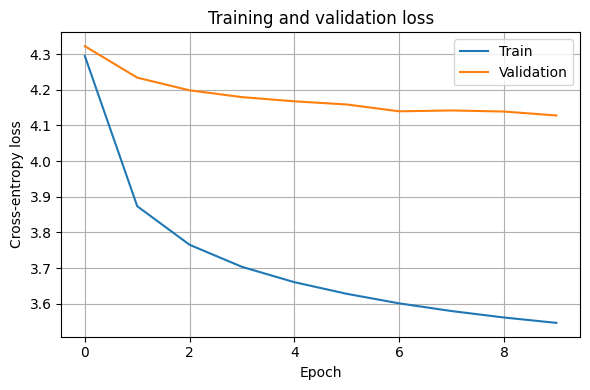

In [ ]:
def plot_losses(train_losses, val_losses):
    """Plot training and validation loss curves on the same figure."""
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Cross-entropy loss")
    plt.title("Training and validation loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_losses(train_losses, val_losses)